Using TensorFlow backend.


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000


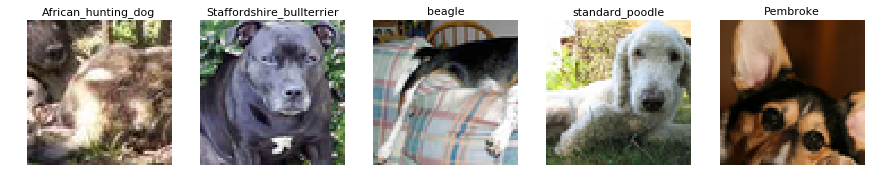

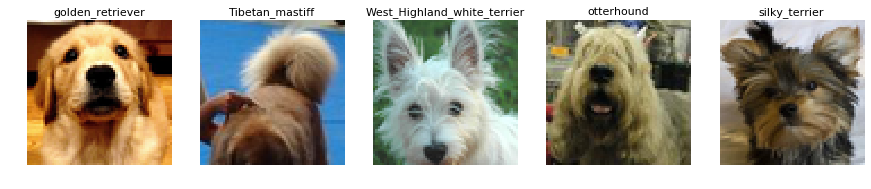

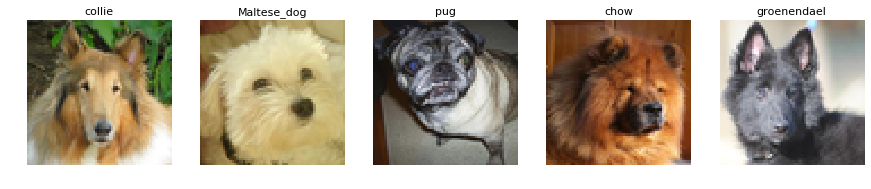

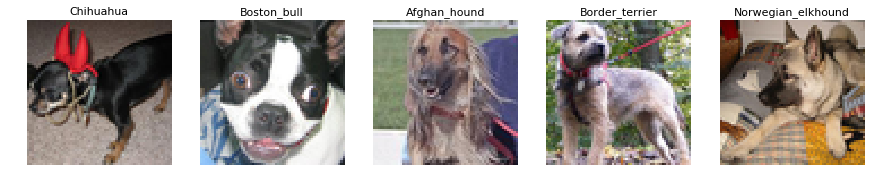

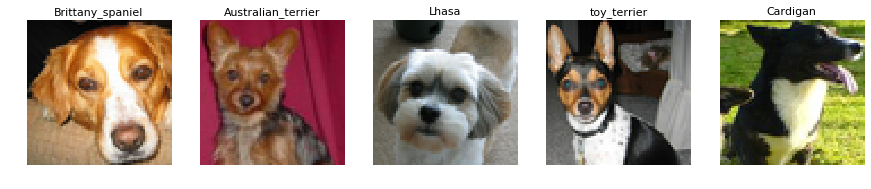

In [1]:
import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Reshape, Flatten, concatenate, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD, Adam

ComputeLB = True
DogsOnly = True
ROOT = './dataset/'
IMAGES = os.listdir(ROOT + 'all-dogs/')
breeds = os.listdir(ROOT + 'Annotation/') 

idxIn = 0; namesIn = []
imagesIn = np.zeros((25000,64,64,3))

# CROP WITH BOUNDING BOXES TO GET DOGS ONLY
if DogsOnly:
    for breed in breeds:
        for dog in os.listdir(ROOT+'Annotation/'+breed):
            try: img = Image.open(ROOT+'all-dogs/'+dog+'.jpg') 
            except: continue           
            tree = ET.parse(ROOT+'Annotation/'+breed+'/'+dog)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox') 
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                w = np.min((xmax - xmin, ymax - ymin))
                img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
                img2 = img2.resize((64,64), Image.ANTIALIAS)
                imagesIn[idxIn,:,:,:] = np.asarray(img2)
                if idxIn%1000==0: print(idxIn)
                namesIn.append(breed)
                idxIn += 1
    idx = np.arange(idxIn)
    np.random.shuffle(idx)
    imagesIn = imagesIn[idx,:,:,:]
    namesIn = np.array(namesIn)[idx]
    
# RANDOMLY CROP FULL IMAGES
else:
    x = np.random.choice(np.arange(20579),10000)
    for k in range(len(x)):
        img = Image.open(ROOT + 'all-dogs/' + IMAGES[x[k]])
        w = img.size[0]
        h = img.size[1]
        sz = np.min((w,h))
        a=0; b=0
        if w<h: b = (h-sz)//2
        else: a = (w-sz)//2
        img = img.crop((0+a, 0+b, sz+a, sz+b))  
        img = img.resize((64,64), Image.ANTIALIAS)   
        imagesIn[idxIn,:,:,:] = np.asarray(img)
        namesIn.append(IMAGES[x[k]])
        if idxIn%1000==0: print(idxIn)
        idxIn += 1
    
# DISPLAY CROPPED IMAGES
x = np.random.randint(0,idxIn,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        if not DogsOnly: plt.title(namesIn[x[k*5+j]],fontsize=11)
        else: plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()

In [2]:
# BUILD DISCRIMINATIVE NETWORK
dog = Input((12288,))
dogName = Input((10000,))
x = Dense(12288, activation='sigmoid')(dogName) 
x = Reshape((2,12288,1))(concatenate([dog,x]))
x = Conv2D(1,(2,1),use_bias=False,name='conv')(x)
discriminated = Flatten()(x)

# COMPILE
discriminator = Model([dog,dogName], discriminated)
discriminator.get_layer('conv').trainable = False
discriminator.get_layer('conv').set_weights([np.array([[[[-1.0 ]]],[[[1.0]]]])])
discriminator.compile(optimizer='adam', loss='binary_crossentropy')

# DISPLAY ARCHITECTURE
discriminator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 12288)        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 12288)        122892288   input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 24576)        0           input_1[0][0]                    
                                                                 dense_1[0][0]                    
__________

In [3]:
# TRAINING DATA
train_y = (imagesIn[:10000,:,:,:]/255.).reshape((-1,12288))
train_X = np.zeros((10000,10000))
for i in range(10000): train_X[i,i] = 1
zeros = np.zeros((10000,12288))

# TRAIN NETWORK
lr = 0.5
for k in range(5):
    annealer = LearningRateScheduler(lambda x: lr)
    h = discriminator.fit([zeros,train_X],
                          train_y,
                          epochs=5,
                          batch_size=256,
                          callbacks=[annealer],
                          verbose=0)
    print('Epoch',(k+1)*10,'/30 - loss =',h.history['loss'][-1] )
    if h.history['loss'][-1]<0.533: lr = 0.1

Epoch 10 /30 - loss = 0.6035054733276367
Epoch 20 /30 - loss = 0.5511094469070434
Epoch 30 /30 - loss = 0.5373072679519654
Epoch 40 /30 - loss = 0.5333879123687744
Epoch 50 /30 - loss = 0.5319916357040405


In [4]:
del train_X, train_y, imagesIn

Discriminator Recalls from Memory Dogs


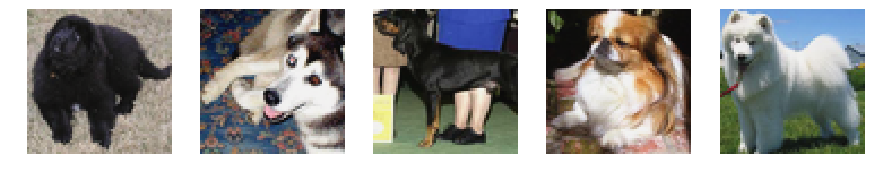

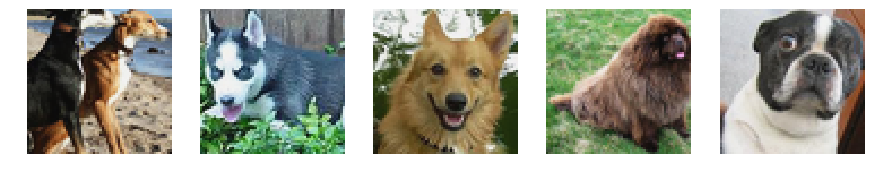

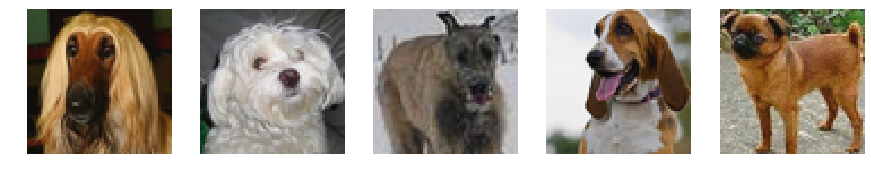

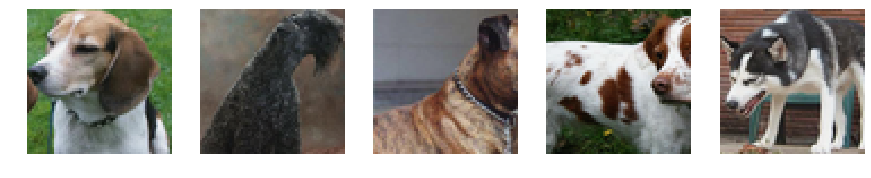

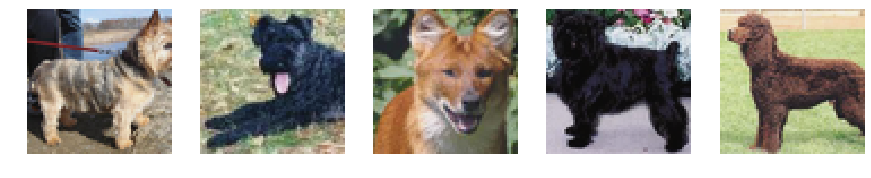

In [5]:
print('Discriminator Recalls from Memory Dogs')    
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        xx = np.zeros((10000))
        xx[np.random.randint(10000)] = 1
        plt.subplot(1,5,j+1)
        img = discriminator.predict([zeros[0,:].reshape((-1,12288)),xx.reshape((-1,10000))]).reshape((-1,64,64,3))
        img = Image.fromarray( (255*img).astype('uint8').reshape((64,64,3)))
        plt.axis('off')
        plt.imshow(img)
    plt.show()

In [6]:
# BUILD GENERATOR NETWORK
BadMemory = True

if BadMemory:
    seed = Input((10000,))
    x = Dense(2048, activation='elu')(seed)
    x = Reshape((8,8,32))(x)
    x = Conv2D(128, (3, 3), activation='elu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='elu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='elu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(3, (3, 3), activation='linear', padding='same')(x)
    generated = Flatten()(x)
else:
    seed = Input((10000,))
    generated = Dense(12288, activation='linear')(seed)

# COMPILE
generator = Model(seed, [generated,Reshape((10000,))(seed)])

# DISPLAY ARCHITECTURE
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2048)         20482048    input_3[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 8, 8, 32)     0           dense_2[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 128)    36992       reshape_2[0][0]                  
__________________________________________________________________________________________________
up_samplin

In [7]:
# BUILD GENERATIVE ADVERSARIAL NETWORK
discriminator.trainable=False    
gan_input = Input(shape=(10000,))
x = generator(gan_input)
gan_output = discriminator(x)

# COMPILE GAN
gan = Model(gan_input, gan_output)
gan.get_layer('model_1').get_layer('conv').set_weights([np.array([[[[-1 ]]],[[[255.]]]])])
gan.compile(optimizer=Adam(5), loss='mean_squared_error')

# DISPLAY ARCHITECTURE
gan.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
model_2 (Model)                 [(None, 12288), (Non 20612163    input_4[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 12288)        122892290   model_2[1][0]                    
                                                                 model_2[1][1]                    
Total params: 143,504,453
Trainable params: 20,612,163
Non-trainable params: 122,892,290
__________________________________________________________________________________________________


Epoch 1 /12 - loss = 9671.97761875


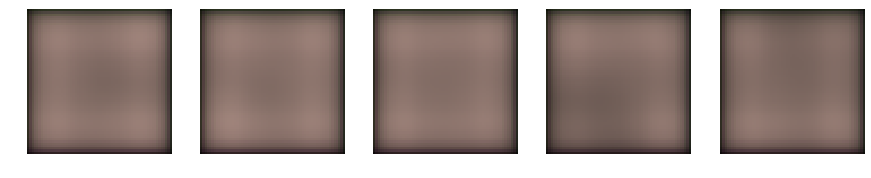

Epoch 2 /12 - loss = 3225.2000421875


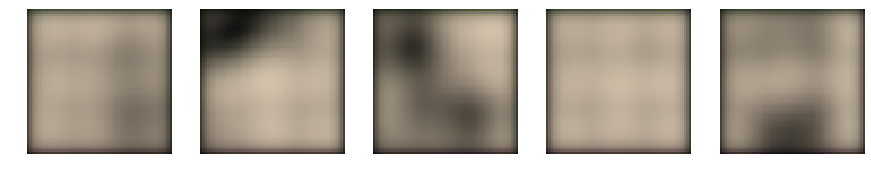

Epoch 3 /12 - loss = 1749.9742900390625


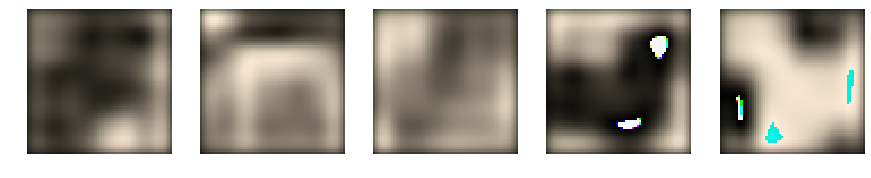

Epoch 4 /12 - loss = 1169.729940234375


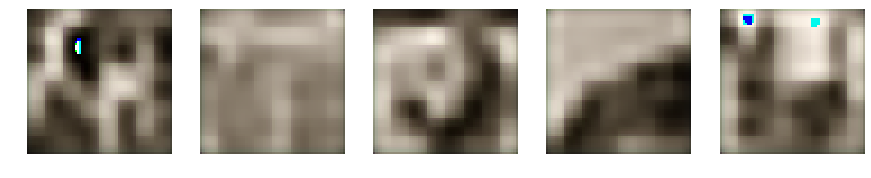

Epoch 5 /12 - loss = 835.9210842773438


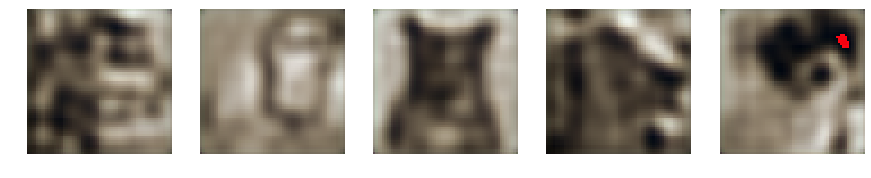

Epoch 6 /12 - loss = 510.3820721679688


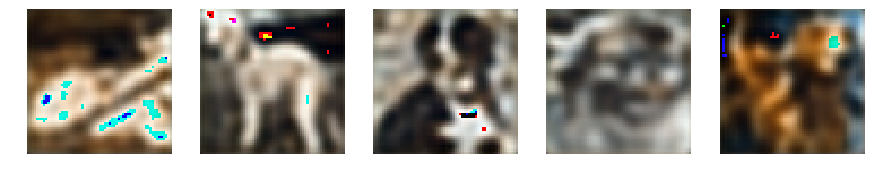

Epoch 7 /12 - loss = 320.74986801757814


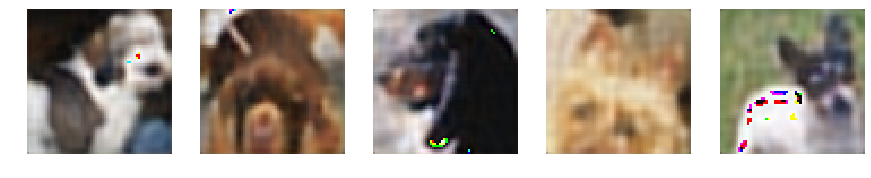

Epoch 8 /12 - loss = 173.030150390625


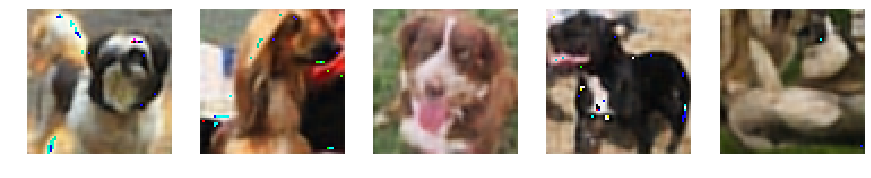

Epoch 9 /12 - loss = 106.23047268066406


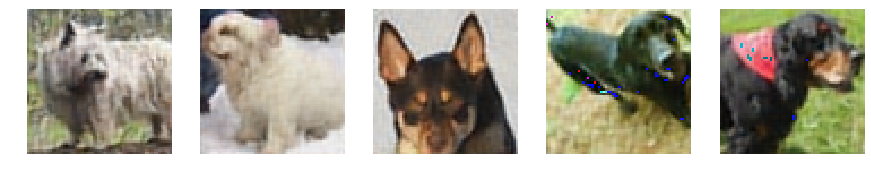

Epoch 10 /12 - loss = 84.72352589111328


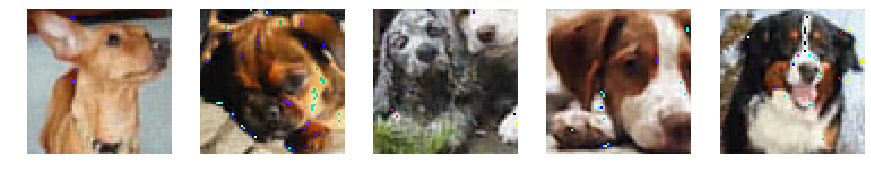

Epoch 11 /12 - loss = 75.66726791992187


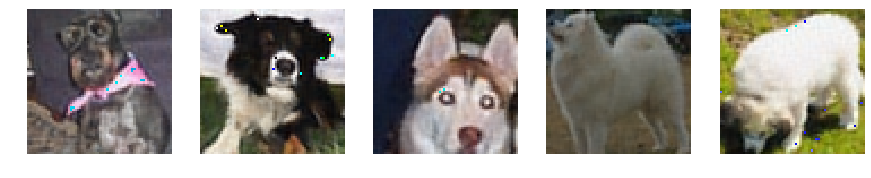

Epoch 12 /12 - loss = 71.39424167480469


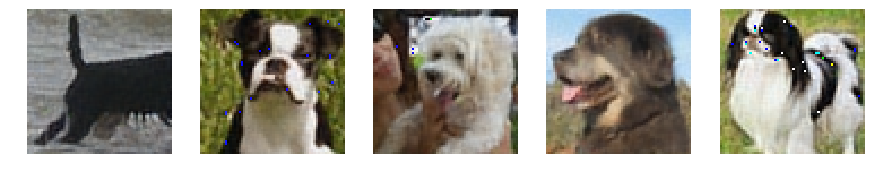

In [8]:
# TRAINING DATA
train = np.zeros((10000,10000))
for i in range(10000): train[i,i] = 1
zeros = np.zeros((10000,12288))

# TRAIN NETWORKS
ep = 1; it = 12
if BadMemory: lr = 0.001
else: lr = 5.
    
for k in range(it):  

    # BEGIN DISCRIMINATOR COACHES GENERATOR
    annealer = LearningRateScheduler(lambda x: lr)
    h = gan.fit(train, zeros, epochs = ep, batch_size=256, callbacks=[annealer], verbose=0)

    # DISPLAY GENERATOR LEARNING PROGRESS 
    print('Epoch',(k+1),'/'+str(it)+' - loss =',h.history['loss'][-1] )
    plt.figure(figsize=(15,3))
    for j in range(5):
        xx = np.zeros((10000))
        xx[np.random.randint(10000)] = 1
        plt.subplot(1,5,j+1)
        img = generator.predict(xx.reshape((-1,10000)))[0].reshape((-1,64,64,3))
        img = Image.fromarray( (img).astype('uint8').reshape((64,64,3)))
        plt.axis('off')
        plt.imshow(img)
    plt.show()  
            
    # ADJUST LEARNING RATES
    if BadMemory:
        ep *= 2
        if ep>=32: lr = 0.001
        if ep>256: ep = 256
    else:
        if h.history['loss'][-1] < 25: lr = 1.
        if h.history['loss'][-1] < 1.5: lr = 0.5

In [9]:
class DogGenerator:
    index = 0   
    def getDog(self,seed):
        xx = np.zeros((10000))
        xx[self.index] = 0.70
        xx[np.random.randint(10000)] = 0.30
        img = generator.predict(xx.reshape((-1,10000)))[0].reshape((64,64,3))
        self.index = (self.index+1)%10000
        return Image.fromarray( img.astype('uint8') ) 

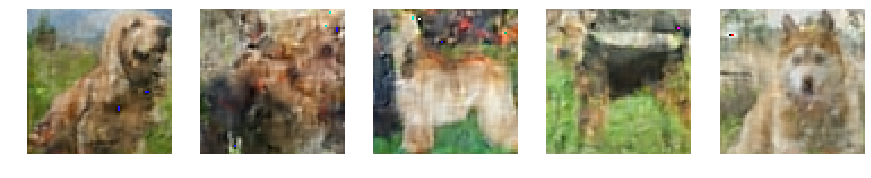

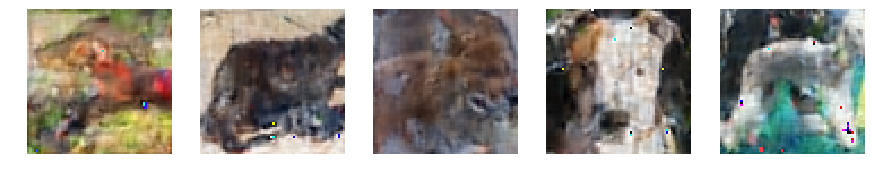

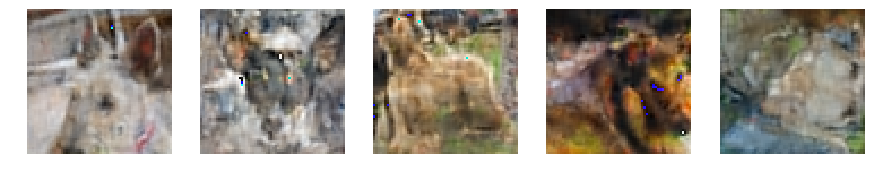

In [10]:
# DISPLAY EXAMPLE DOGS
d = DogGenerator()
for k in range(3):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = d.getDog(np.random.normal(0,1,100))
        plt.axis('off')
        plt.imshow(img)
    plt.show() 

In [11]:
# SAVE TO ZIP FILE NAMED IMAGES.ZIP
z = zipfile.PyZipFile('images.zip', mode='w')
d = DogGenerator()
for k in range(10000):
    img = d.getDog(np.random.normal(0,1,100))
    f = str(k)+'.png'
    img.save(f,'PNG'); 
    z.write(f); 
    os.remove(f)
    if k % 1000==0: print(k)
z.close()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [12]:
!ls

__notebook_source__.ipynb  images.zip
